<a href="https://colab.research.google.com/github/FREDY129053/Final_theory_work/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [55]:
df = pd.read_csv('/content/ibm_data.csv')

In [56]:
df['Date_point'] = pd.to_datetime(df['Date_point'])

In [57]:
df.head(15)

,Date_point,Name,Open,High,Low,Close,Volume
0,2018-12-31,International Business Machines Corp,113.33,114.35,112.4201,113.67,4982755.0
1,2018-12-28,International Business Machines Corp,114.22,114.80,112.5000,113.03,5117533.0
2,2018-12-27,International Business Machines Corp,109.99,113.78,109.4700,113.78,6045590.0
3,2018-12-26,International Business Machines Corp,108.00,111.39,105.9400,111.39,6645794.0
4,2018-12-24,International Business Machines Corp,109.90,111.00,107.5000,107.57,3821376.0
5,2018-12-21,International Business Machines Corp,112.50,115.28,110.4400,110.94,10386453.0
6,2018-12-20,International Business Machines Corp,115.70,116.45,111.7000,113.02,8454350.0
7,2018-12-19,International Business Machines Corp,117.15,120.27,115.9700,116.43,6979823.0
8,2018-12-18,International Business Machines Corp,116.90,118.23,116.0200,116.65,6290186.0
9,2018-12-17,International Business Machines Corp,119.07,119.78,115.0700,116.10,7374476.0


In [66]:
copy_df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
copy_df.shape

(4822, 5)

In [67]:
np_ds_scaled = np.reshape(copy_df, (copy_df.shape[0], copy_df.shape[1]))

In [68]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the sequence
      if out_end_ix > len(sequence):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
      X.append(seq_x)
      tmp = [i[-2] for i in seq_y]
      y.append(tmp)
  return np.array(X), np.array(y)

In [69]:
n_steps_in, n_steps_out = 30, 90
x, y = split_sequence(np_ds_scaled, n_steps_in, n_steps_out)

In [70]:
x = x.reshape((x.shape[0], x.shape[1], 5))

In [71]:
# train_size = int(len(ds_scaled)*0.70)
# test_size = len(ds_scaled) - train_size

splitlimit = int(len(x)*0.8)
x_train, x_test = x[:splitlimit], x[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

In [72]:
from sklearn.preprocessing import MinMaxScaler

normalizer1 = MinMaxScaler(feature_range=(0,1))
normalizer2 = MinMaxScaler(feature_range=(0,1))
normalizer3 = MinMaxScaler(feature_range=(0,1))
normalizer4 = MinMaxScaler(feature_range=(0,1))

x_train_tmp = x_train.reshape(-1, x_train.shape[-1])
x_test_tmp = x_test.reshape(-1, x_test.shape[-1])

x_train_scaled = normalizer1.fit_transform(x_train_tmp)
x_test_scaled = normalizer2.fit_transform(x_test_tmp)

x_train = x_train_scaled.reshape(x_train.shape)
x_test = x_test_scaled.reshape(x_test.shape)
y_train = normalizer3.fit_transform(y_train)
y_test = normalizer4.fit_transform(y_test)

In [73]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(n_steps_in, 5)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, batch_size=15, epochs=50, shuffle=True, validation_split = 0.1)

Epoch 1/50
226/226 [==============================] - 18s 64ms/step - loss: 0.0332 - val_loss: 0.0024
Epoch 2/50
226/226 [==============================] - 18s 78ms/step - loss: 0.0104 - val_loss: 0.0036
Epoch 3/50
226/226 [==============================] - 15s 66ms/step - loss: 0.0088 - val_loss: 0.0035
Epoch 4/50
226/226 [==============================] - 15s 67ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 5/50
226/226 [==============================] - 16s 72ms/step - loss: 0.0082 - val_loss: 0.0028
Epoch 6/50
226/226 [==============================] - 17s 75ms/step - loss: 0.0072 - val_loss: 0.0030
Epoch 7/50
226/226 [==============================] - 15s 65ms/step - loss: 0.0073 - val_loss: 0.0026
Epoch 8/50
226/226 [==============================] - 14s 63ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 9/50
226/226 [==============================] - 14s 63ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 10/50
226/226 [==============================] - 14s 62ms/step - loss: 0.006

In [74]:
predict = model.predict(x_test)
predict

30/30 [==============================] - 1s 28ms/step


array([[0.49410638, 0.49613145, 0.4956649 , ..., 0.5476347 , 0.5485109 ,
        0.548393  ],
       [0.49299276, 0.49503696, 0.49459574, ..., 0.54745126, 0.5483191 ,
        0.54820967],
       [0.4923464 , 0.4943996 , 0.49397236, ..., 0.5474324 , 0.5482987 ,
        0.54819024],
       ...,
       [0.6995769 , 0.7005371 , 0.6979805 , ..., 0.67999756, 0.68106335,
        0.6806462 ],
       [0.6816307 , 0.68258417, 0.6801477 , ..., 0.6633495 , 0.664335  ,
        0.6639378 ],
       [0.67613024, 0.6770641 , 0.6746582 , ..., 0.65871125, 0.6596842 ,
        0.65932345]], dtype=float32)

In [75]:
y_test

array([[0.45277495, 0.46270367, 0.44844705, ..., 0.33172098, 0.33350305,
        0.33324847],
       [0.46270367, 0.44844705, 0.45417515, ..., 0.33350305, 0.33324847,
        0.32955703],
       [0.44844705, 0.45417515, 0.45748473, ..., 0.33324847, 0.32955703,
        0.34024949],
       ...,
       [0.66980652, 0.63874745, 0.67375255, ..., 0.44781059, 0.46448574,
        0.50025458],
       [0.63874745, 0.67375255, 0.65147658, ..., 0.46448574, 0.50025458,
        0.5058554 ],
       [0.67375255, 0.65147658, 0.61010692, ..., 0.50025458, 0.5058554 ,
        0.5305499 ]])

In [76]:
predict.shape

(941, 90)

In [77]:
y_test.shape

(941, 90)

In [78]:
for i in normalizer4.inverse_transform(predict):
  print(i)

Выходные данные были обрезаны до нескольких последних строк (5000).
 106.3952   106.23769  106.20413  106.16774  106.26033  106.04653
 106.14233  105.96316  106.098976 106.03814  106.02619  105.98116
 106.06043  106.13407  106.11353  106.07031  106.03361  105.89565
 105.78319  105.77154  105.754265 105.8295   105.924164 105.888824]
[107.27959  107.347    107.15622  107.181335 107.002075 106.937775
 106.74037  106.83262  106.671936 106.646255 106.602165 106.64802
 106.666374 106.78477  106.857895 106.82925  106.80096  106.783844
 106.84205  106.92059  106.85086  106.728714 106.634    106.69289
 106.675514 106.57724  106.50593  106.66899  106.54663  106.55471
 106.73416  106.67511  106.64581  106.64625  106.60051  106.65745
 106.63172  106.62317  106.64417  106.619896 106.699165 106.86094
 106.93281  106.952034 106.950874 106.965546 106.72687  106.782005
 106.816765 106.82728  106.91748  106.918594 106.908264 106.82353
 106.95591  107.06316  107.107376 107.07395  107.05837  107.279655
 1

In [79]:
model.save('/content/LSTM_IBM_NICE.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
normalizer4.data_min_

array([55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07,
       55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07, 55.07])

In [84]:
len(normalizer4.data_min_)

90

In [81]:
normalizer4.data_max_

array([133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63, 133.63,
       133.63, 133.63])

In [82]:
normalizer1.data_max_

array([2.15380e+02, 2.15900e+02, 2.14300e+02, 2.15800e+02, 3.07707e+07])

In [85]:
normalizer1.data_min_

array([7.25300e+01, 7.36900e+01, 6.95000e+01, 7.17400e+01, 1.92843e+05])

## Another

In [ ]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [ ]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]
len(ds_train),len(ds_test)

(3375, 1447)

In [ ]:
def create_ds(dataset,step):
  Xtrain, Ytrain = [], []
  for i in range(len(dataset)-step-1):
      a = dataset[i:(i+step), 0]
      Xtrain.append(a)
      Ytrain.append(dataset[i + step, 0])
  return np.array(Xtrain), np.array(Ytrain)

In [ ]:
time_stamp = 20
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(3354, 20) (3354,)
(1426, 20) (1426,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            30200     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 91251 (356.45 KB)
Trainable params: 91251 (356.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
53/53 [==============================] - 8s 61ms/step - loss: 0.0206 - val_loss: 0.0013
Epoch 2/100
53/53 [==============================] - 2s 43ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/100
53/53 [==============================] - 2s 42ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/100
53/53 [==============================] - 2s 47ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
53/53 [==============================] - 3s 48ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
53/53 [==============================] - 2s 46ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
53/53 [==============================] - 2s 46ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
53/53 [==============================] - 2s 46ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
53/53 [==============================] - 2s 47ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/100
53/53 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 0.0010

45/45 [==============================] - 0s 10ms/step


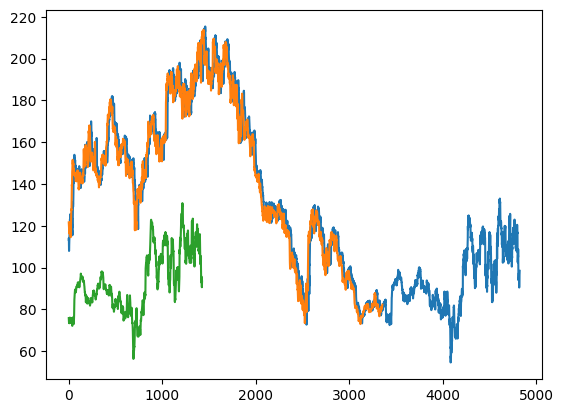

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [ ]:
len(ds_test)

1447

In [ ]:
fut_inp = ds_test[1427:]
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)
fut_inp.shape

(1, 20)

In [ ]:
tmp_inp

[0.312884962359236,
 0.31910657624587824,
 0.31325825919243455,
 0.33696260810054135,
 0.31636906613575566,
 0.27592857587258135,
 0.24482050643937037,
 0.25023331052074915,
 0.24867790704908854,
 0.2572637342126548,
 0.2572637342126548,
 0.266596155042618,
 0.24867790704908854,
 0.2514154171592111,
 0.2230448578361227,
 0.23704348908106765,
 0.24755801654949294,
 0.25645492440739137,
 0.2619299446276364,
 0.27281776892926024]

In [ ]:
tmp_inp = [tmp_inp[0]]

lst_output=[]
n_steps=20
i=0
while(i<90):
  if(len(tmp_inp)>20):
      fut_inp = np.array(tmp_inp[1:])
      fut_inp=fut_inp.reshape(1,-1)
      fut_inp = fut_inp.reshape((1, n_steps, 1))
      yhat = model.predict(fut_inp, verbose=0)
      tmp_inp.extend(yhat[0].tolist())
      tmp_inp = tmp_inp[1:]
      lst_output.extend(yhat.tolist())
      i=i+1
  else:
      fut_inp = fut_inp.reshape((1, n_steps,1))
      yhat = model.predict(fut_inp, verbose=0)
      tmp_inp.extend(yhat[0].tolist())
      lst_output.extend(yhat.tolist())
      i=i+1


print(lst_output)

[[0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.2592029571533203], [0.25013577938079834], [0.24590998888015747], [0.24043141305446625], [0.23488688468933105], [0.22953195869922638], [0.22436581552028656], [0.21934007108211517], [0.21441109478473663], [0.20955298840999603], [0.20475775003433228], [0.20003098249435425], [0.19538557529449463], [0.19083653390407562], [0.18639639019966125], [0.18207311630249023], [0.17786896228790283], [0.17378054559230804], [0.16979962587356567], [0.16591422259807587], [0.1621096283197403], [0.1583695411682129], [0.1547212451696396], [0.1511455923318863], [0.14764803647994995], [0.14422926

In [ ]:
len(ds_scaled)

4822

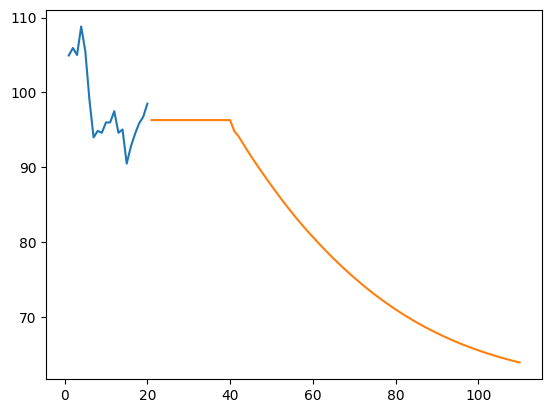

In [ ]:
plot_new=np.arange(1,21)
plot_pred=np.arange(21,111)

plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[4802:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()
len(ds_new)

4822

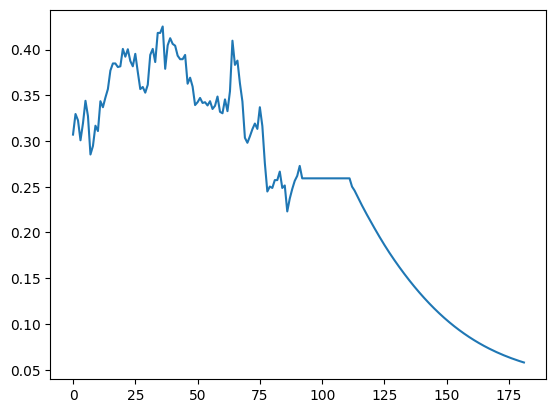

In [ ]:
ds_new.extend(lst_output)
plt.plot(ds_new[4730:])

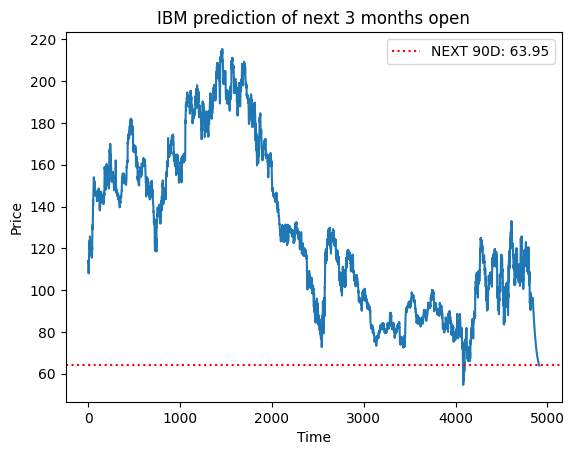

In [ ]:
final_graph = normalizer.inverse_transform(ds_new).tolist()
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next 3 months open".format("IBM"))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 90D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

## Генерация признаков

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=249e7f6d3cc688e7142ce359e23b1e05bbd587a0a594deec015aa3c866dde620
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [ ]:
import pandas_ta as ta

copy_df = df.copy()
# Признаки
copy_df['RSI']=ta.rsi(copy_df.Close, length=10)
copy_df['EMAF']=ta.ema(copy_df.Close, length=15)
copy_df['EMAM']=ta.ema(copy_df.Close, length=50)
copy_df['EMAS']=ta.ema(copy_df.Close, length=75)

# Разница между акцией следующей акции и сегодняшней
copy_df['Target'] = copy_df['Close'] - copy_df.Open
copy_df['Target'] = copy_df['Target'].shift(-1)

# Столбец: если 0, то акция упала в цене, если 1, то акция вырастает
copy_df['TargetClass'] = [1 if copy_df.Target[i] > 0 else 0 for i in range(len(copy_df))]

# Столбец показывающий стоимость акции следующего дня
copy_df['TargetNextClose'] = copy_df['Close'].shift(-1)
copy_df.dropna(inplace=True)
copy_df.reset_index(inplace = True)
print(copy_df.head(25))

dates = copy_df['Date_point']
copy_df.drop(['Date_point', 'Name'], axis=1, inplace=True)
copy_df.drop('index', axis=1, inplace=True)

    index Date_point                                  Name    Open    High  \
0      74 2018-09-13  International Business Machines Corp  147.35  149.00   
1      75 2018-09-12  International Business Machines Corp  146.37  147.98   
2      76 2018-09-11  International Business Machines Corp  146.00  146.99   
3      77 2018-09-10  International Business Machines Corp  146.60  147.30   
4      78 2018-09-07  International Business Machines Corp  145.94  146.50   
5      79 2018-09-06  International Business Machines Corp  146.88  147.66   
6      80 2018-09-05  International Business Machines Corp  145.19  146.75   
7      81 2018-09-04  International Business Machines Corp  145.98  146.19   
8      82 2018-08-31  International Business Machines Corp  145.72  146.78   
9      83 2018-08-30  International Business Machines Corp  147.03  147.30   
10     84 2018-08-29  International Business Machines Corp  146.87  147.93   
11     85 2018-08-28  International Business Machines Corp  146.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(copy_df)
print(data_set_scaled)
print(data_set_scaled.shape)

[[0.57674361 0.57977387 0.58088465 ... 0.515      1.         0.56927767]
 [0.57064643 0.57336683 0.57408447 ... 0.52818182 1.         0.56877994]
 [0.56834443 0.56714824 0.56921829 ... 0.46272727 0.         0.56355379]
 ...
 [0.24755802 0.2370603  0.22453054 ... 0.43772727 0.         0.24450943]
 [0.25645492 0.24648241 0.24636596 ... 0.41772727 0.         0.24724694]
 [0.26192994 0.25194724 0.24755131 ... 0.42636364 0.         0.25931687]]
(4747, 12)


In [ ]:
X = []
backcandles = 15  # сколько дней будет учитываться для предсказывания цены
for j in range(9):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])
print(X[0])
print(len(X))
X = np.moveaxis(X, [0], [2])
print(X.shape)
dates = np.array(dates[backcandles:])
X, yi = np.array(X), np.array(data_set_scaled[backcandles:,-1])
print('\n\n')
y = np.reshape(yi,(len(yi),1))

print(X.shape)
print(y.shape)

[array([0.57674361, 0.57064643, 0.56834443, 0.5720774 , 0.56797113,
       0.57381945, 0.56330492, 0.56822   , 0.56660238, 0.57475269,
       0.57375723, 0.57425496, 0.57419275, 0.56498476, 0.56237168]), array([0.57064643, 0.56834443, 0.5720774 , 0.56797113, 0.57381945,
       0.56330492, 0.56822   , 0.56660238, 0.57475269, 0.57375723,
       0.57425496, 0.57419275, 0.56498476, 0.56237168, 0.56840664]), array([0.56834443, 0.5720774 , 0.56797113, 0.57381945, 0.56330492,
       0.56822   , 0.56660238, 0.57475269, 0.57375723, 0.57425496,
       0.57419275, 0.56498476, 0.56237168, 0.56840664, 0.57456604]), array([0.5720774 , 0.56797113, 0.57381945, 0.56330492, 0.56822   ,
       0.56660238, 0.57475269, 0.57375723, 0.57425496, 0.57419275,
       0.56498476, 0.56237168, 0.56840664, 0.57456604, 0.57064643]), array([0.56797113, 0.57381945, 0.56330492, 0.56822   , 0.56660238,
       0.57475269, 0.57375723, 0.57425496, 0.57419275, 0.56498476,
       0.56237168, 0.56840664, 0.57456604, 0.57064643

## Модель

In [ ]:
# Разделение датасета
splitlimit = int(len(X)*0.8)
print(splitlimit)
dates = np.reshape(dates, (len(dates), 1))
print(dates.shape)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
dates_train, dates_test = dates[:splitlimit], dates[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(dates_test.shape)

3785
(4732, 1)
(3785, 15, 9)
(947, 15, 9)
(3785, 1)
(947, 1)
(947, 1)


In [ ]:
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras.layers import Input, Activation
from keras.models import Model

lstm_input = Input(shape=(backcandles, 9), name='lstm_input')
inputs = LSTM(250, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse')
history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
228/228 [==============================] - 10s 13ms/step - loss: 0.0035 - val_loss: 1.0843e-04
Epoch 2/30
228/228 [==============================] - 2s 7ms/step - loss: 3.8675e-04 - val_loss: 1.0250e-04
Epoch 3/30
228/228 [==============================] - 2s 8ms/step - loss: 3.6130e-04 - val_loss: 8.2289e-05
Epoch 4/30
228/228 [==============================] - 2s 11ms/step - loss: 3.3313e-04 - val_loss: 9.5888e-05
Epoch 5/30
228/228 [==============================] - 2s 10ms/step - loss: 3.7707e-04 - val_loss: 1.0546e-04
Epoch 6/30
228/228 [==============================] - 2s 8ms/step - loss: 3.4874e-04 - val_loss: 9.3512e-05
Epoch 7/30
228/228 [==============================] - 2s 9ms/step - loss: 3.1138e-04 - val_loss: 7.6212e-05
Epoch 8/30
228/228 [==============================] - 2s 8ms/step - loss: 3.1306e-04 - val_loss: 7.9182e-05
Epoch 9/30
228/228 [==============================] - 2s 7ms/step - loss: 3.0052e-04 - val_loss: 9.6182e-05
Epoch 10/30
228/228 [=======

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

30/30 [==============================] - 0s 2ms/step
Mean Squared Error: 0.00033598426559848933
Mean Absolute Error: 0.013224586391030595


In [ ]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

30/30 [==============================] - 0s 3ms/step
[0.16345066] [0.16057985]
[0.16132107] [0.15939775]
[0.16123764] [0.15354943]
[0.15564136] [0.15417159]
[0.15438649] [0.16213526]
[0.16007383] [0.16300628]
[0.15942194] [0.16288185]
[0.16092674] [0.16107758]
[0.16622041] [0.16630374]
[0.16667433] [0.17090773]


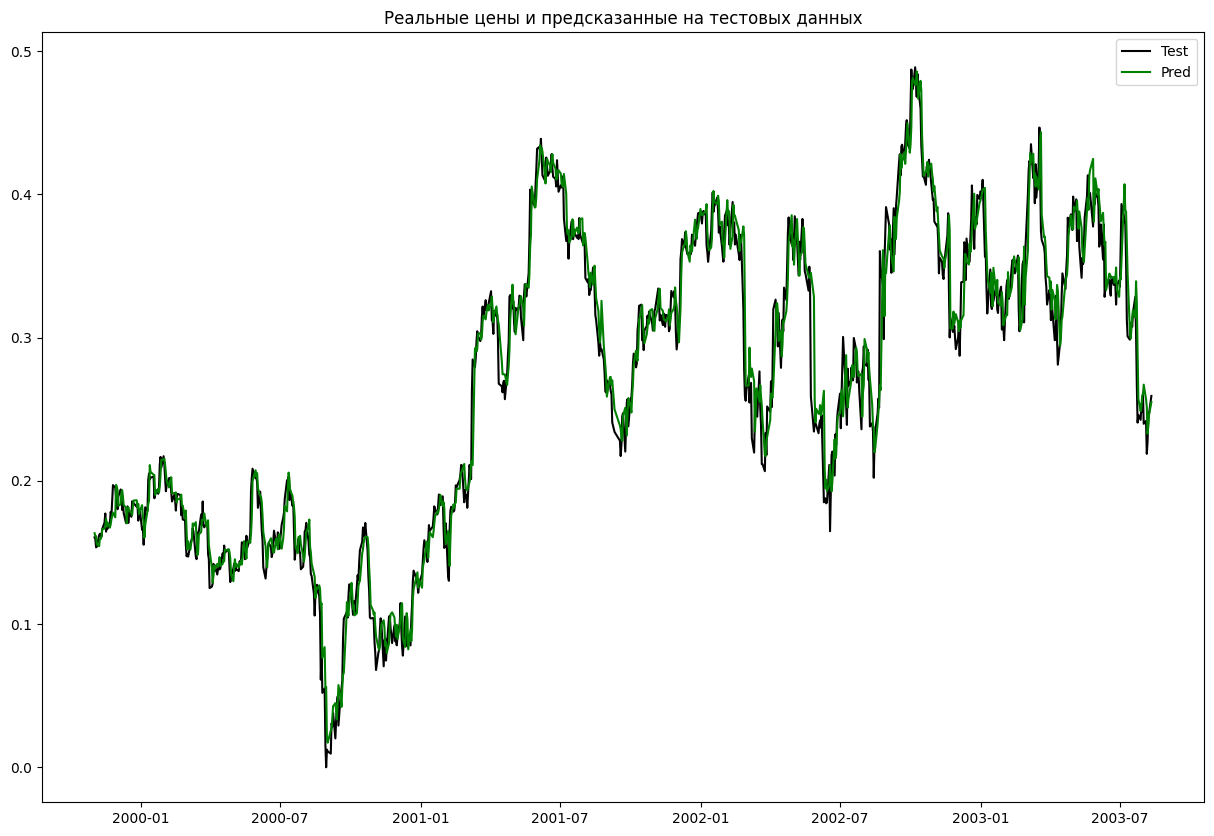

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.title('Реальные цены и предсказанные на тестовых данных')
plt.plot(dates_test[::-1], y_test, color = 'black', label = 'Test')
plt.plot(dates_test[::-1], y_pred, color = 'green', label = 'Pred')
# plt.plot(y_test, color = 'black', label = 'Test')
# plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model.save('/content/drive/MyDrive/H5_ANALITICA_MODEL_IBM.h5')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
